In [1]:
# LSTM for wind prediction and time series implementation with regression framing

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In C:\Users\Afrid\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Afrid\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Afrid\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Afrid\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Afrid\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
import numpy as np
from numpy import genfromtxt

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
### convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [4]:
### fix random seed for reproducibility
numpy.random.seed(7)

### load the dataset
dataframe = pd.read_excel('mast.xlsx', index_col=None, skipfooter=3)
# dataset = dataframe.drop(columns=["Date/Time"])
dataframe = pd.DataFrame(dataframe)
dataframe

,Date/Time,WS_50_mean,WS_50_stdev,WS_80_mean,WS_80_stdev,WS_100_mean,WS_100_stdev,Ta_10_mean,Pbaro_5_mean
0,2013-10-01 10:00:00,5.62,0.43,5.71,0.43,5.61,0.43,27.81,1004.2
1,2013-10-01 10:10:00,5.72,0.48,5.85,0.50,5.85,0.43,27.82,1004.1
2,2013-10-01 10:20:00,6.00,0.36,6.05,0.46,6.05,0.37,27.76,1003.9
3,2013-10-01 10:30:00,6.49,0.41,6.58,0.53,6.46,0.43,27.77,1003.9
4,2013-10-01 10:40:00,6.74,0.45,6.82,0.56,6.86,0.39,27.80,1003.8
...,...,...,...,...,...,...,...,...,...
104941,2015-09-30 22:30:00,7.78,0.55,7.94,0.50,7.99,0.50,27.59,1010.5
104942,2015-09-30 22:40:00,7.58,0.59,7.57,0.63,7.60,0.62,27.63,1010.5
104943,2015-09-30 22:50:00,8.02,0.60,8.04,0.67,8.17,0.63,27.55,1010.4
104944,2015-09-30 23:00:00,8.76,0.64,8.14,0.74,9.01,0.57,27.46,1010.4


In [5]:
df = dataframe[['Date/Time','WS_50_mean']].copy()
df['Date/Time']= pd.to_datetime(df['Date/Time'])
df.set_index('Date/Time', inplace=True)

dataframe=pd.DataFrame(df)
dataframe['WS_50_mean'].isna().sum()

0

In [6]:
dataset = dataframe.values
dataset = dataset.astype('float32')

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(train, test)

[[0.2443439 ]
 [0.24886876]
 [0.26153848]
 ...
 [0.26561087]
 [0.2642534 ]
 [0.26289594]] [[0.24886876]
 [0.23710407]
 [0.240724  ]
 ...
 [0.35294122]
 [0.38642535]
 [0.37918556]]


In [9]:
# reshape into X=t and Y=t+1
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
trainX.shape

(83949, 6)

In [11]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
print(trainX.shape)
print(testX.shape)

(83949, 1, 6)
(20983, 1, 6)


In [14]:
# create and fit the LSTM network
epochs = 10

model = Sequential()
model.add(LSTM(units = 8, activation = 'relu', input_shape = (1, look_back)))        
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=64, verbose=1)

Epoch 1/10
1312/1312 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 2/10
1312/1312 [==============================] - 1s 1ms/step - loss: 0.0013
Epoch 3/10
1312/1312 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 4/10
1312/1312 [==============================] - 1s 1ms/step - loss: 8.0060e-04
Epoch 5/10
1312/1312 [==============================] - 1s 1ms/step - loss: 6.2278e-04
Epoch 6/10
1312/1312 [==============================] - 1s 1ms/step - loss: 5.7009e-04
Epoch 7/10
1312/1312 [==============================] - 1s 966us/step - loss: 5.4602e-04
Epoch 8/10
1312/1312 [==============================] - 1s 959us/step - loss: 5.3524e-04
Epoch 9/10
1312/1312 [==============================] - 1s 1ms/step - loss: 5.2741e-04
Epoch 10/10
1312/1312 [==============================] - 1s 992us/step - loss: 5.1818e-04


In [15]:
# make predictions
trainPredict = model.predict(trainX, verbose = 1)
testPredict = model.predict(testX, verbose = 1)
print(trainPredict, testPredict)

656/656 [==============================] - 0s 581us/step
[[0.3112009 ]
 [0.31400567]
 [0.31542632]
 ...
 [0.27141643]
 [0.2677501 ]
 [0.2693655 ]] [[0.22237471]
 [0.23326865]
 [0.22164986]
 ...
 [0.3480942 ]
 [0.3395512 ]
 [0.35575125]]


In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYinv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYinv = scaler.inverse_transform([testY])

In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYinv[0], trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYinv[0], testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.507 RMSE
Test Score: 0.533 RMSE


In [18]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

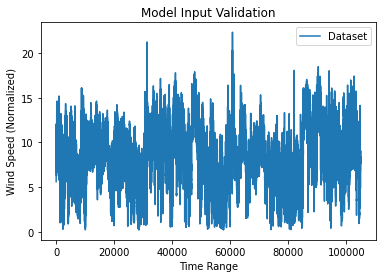

In [19]:
# plot baseline 
val_from = 0
val_to = -1

plt.plot(scaler.inverse_transform(dataset)[val_from:val_to],  label = 'Dataset')
plt.xlabel('Time Range')
plt.ylabel('Wind Speed (Normalized)')
plt.legend()
plt.title('Model Input Validation')
plt.show()

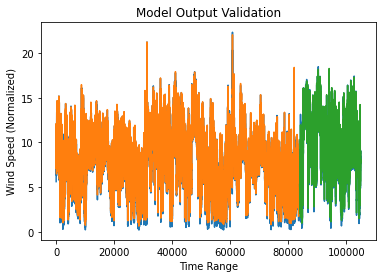

In [20]:
# plot baseline and predictions
plt.xlabel('Time Range')
plt.ylabel('Wind Speed (Normalized)')
plt.title('Model Output Validation')

plt.plot(scaler.inverse_transform(dataset)[val_from:val_to],  label = 'Dataset')
plt.plot(trainPredictPlot[val_from:val_to],  label = 'Train')
plt.plot(testPredictPlot[val_from:val_to],  label = 'Test')
plt.show()

In [21]:
pred = np.concatenate((trainPredict, testPredict))
tpr1=pd.DataFrame(trainPredict)
tpr2=pd.DataFrame(testPredict)
u=trainPredict.reshape(83949)
v=testPredict.reshape(20983)

In [22]:
from sklearn.metrics import mean_squared_error
mean_squared_error(testPredict,testY), mean_squared_error(trainPredict,trainY) 

(98.97933, 67.576126)

In [23]:
from sklearn.metrics import r2_score
r2_score(testPredict,testY), r2_score(trainPredict,trainY)

(-8.61019529463148, -5.70976363392698)

In [30]:
import lime
import numpy as np
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(train),
    feature_names=df.columns,
    class_names=['bad', 'good'],
    mode='regression'
)

In [36]:
exp = explainer.explain_instance(
    data_row=trainPredict.iloc[1], 
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_table=True)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [26]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[4], 
    predict_fn=model.predict_proba
)

exp.show_in_notebook(show_table=True)

NameError: name 'explainer' is not defined